In [1]:
import pandas as pd
import numpy as np

In [2]:
# load the data
df = pd.read_csv('reykjavik_temperature_data.csv',index_col='date')

In [4]:
# size of our data
len(df)

883

<AxesSubplot:xlabel='date'>

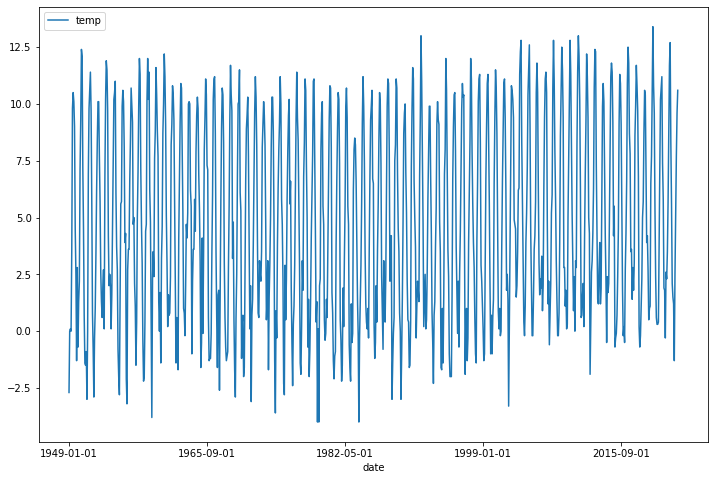

In [3]:
# how does our data look like?
df.plot(figsize=(12,8))

In [5]:
# split the data into test and train
# we'll take 30 months 
test_size = 30
test_idx = len(df) - test_size # index where we split between train/test

In [6]:
train = df.iloc[:test_idx]
test = df.iloc[test_idx:]

In [7]:
# scale the data
# let's use MinMaxScaler so data will be scaled between 0 and 1
from sklearn.preprocessing import MinMaxScaler

In [8]:
# create scaler object
scaler = MinMaxScaler()

In [9]:
# fit the scaler to the train data
# transform both the test and train data
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [11]:
# load the keras TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [12]:
# we can do 24 months at a time to get seasonality info
length = 24
# only feature is temperature
n_features = 1

In [13]:
# create the generator
generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)

In [15]:
# create a validation generator
val_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)

In [35]:
# create early stopping based on validation loss
from tensorflow.keras.callbacks import EarlyStopping
# validation loss is noisy so we can use a high patience value
early_stop = EarlyStopping(monitor='val_loss',patience=20)

In [32]:
# import mean squared error
from sklearn.metrics import mean_squared_error

In [33]:
def check_model(model):
    # fit the model
    model.fit(generator,epochs=150,
             validation_data=val_generator,
             callbacks=[early_stop],
             verbose=0)
    
    # print the summary of the model
    model.summary()
    
    # plot the loss and validation loss
    losses = pd.DataFrame(model.history.history)
    losses.plot()
    
    # compare predictions to test
    
    # empty array for predictions
    predictions = []
    
    # make a prediction from the tail of our timeseries
    ts_tail = scaled_train[-length:]
    
    # current timeseries batch to predict on that we will update for every prediction
    current_ts = ts_tail.reshape((1,length,n_features))
    
    for i in range(len(test)):
        # predict one sample
        tmp_pred = model.predict(current_ts)[0]
        
        # add to prediction list
        predictions.append(tmp_pred)
        
        # update current_ts based on new prediction
        current_ts = np.append(current_ts[:,1:,:],[[tmp_pred]],axis=1)
        
    # reverse the scaler transformation
    fixed_preds = scaler.inverse_transform(predictions)
    
    # make a df with test and predictions
    test_preds_df = test.copy()
    test_preds_df['preds'] = fixed_preds
    
    # plot the predictions vs test
    test_preds_df.plot()
    
    # calculate the RMSE
    print("Root mean squared error:\n")
    print("{} deg celsius".format(np.sqrt(mean_squared_error(test_preds_df.temp,test_preds_df.preds))))

In [19]:
# make some variations of models and see how they perform

In [51]:
# import TF Keras model/layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout

In [37]:
model_1_LSTM = Sequential()
model_1_LSTM.add(LSTM(100,activation='tanh',input_shape=(length,n_features))) # tanh to use cuDNN
model_1_LSTM.add(Dense(1))
model_1_LSTM.compile(optimizer='adam',loss='mse')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Root mean squared error:

1.2423386819955955 deg celsius


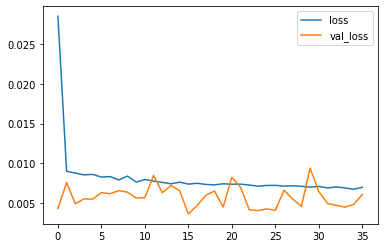

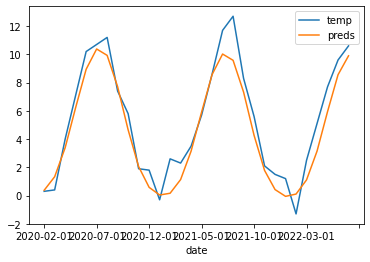

In [38]:
check_model(model_1_LSTM)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 24, 100)           40800     
                                                                 
 lstm_11 (LSTM)              (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
Root mean squared error:

1.660920835256877 deg celsius


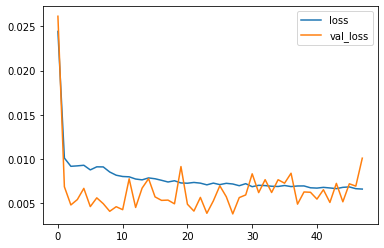

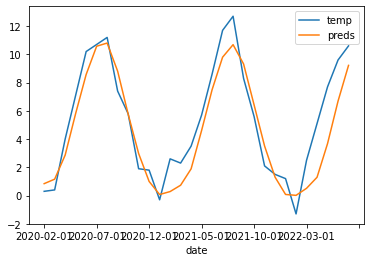

In [43]:
model_2_LSTM = Sequential()
model_2_LSTM.add(LSTM(100,activation='tanh',input_shape=(length,n_features),
                     return_sequences=True)) # tanh to use cuDNN
model_2_LSTM.add(LSTM(100,activation='tanh')) # tanh to use cuDNN
model_2_LSTM.add(Dense(1))
model_2_LSTM.compile(optimizer='adam',loss='mse')
check_model(model_2_LSTM)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 24, 100)           40800     
                                                                 
 lstm_23 (LSTM)              (None, 200)               240800    
                                                                 
 dense_27 (Dense)            (None, 200)               40200     
                                                                 
 dense_28 (Dense)            (None, 100)               20100     
                                                                 
 dense_29 (Dense)            (None, 50)                5050      
                                                                 
 dense_30 (Dense)            (None, 1)                 51        
                                                                 
Total params: 347,001
Trainable params: 347,001
Non-t

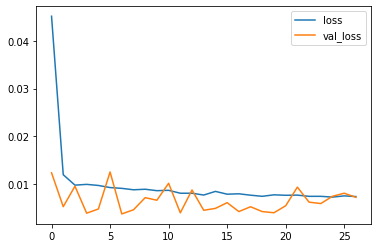

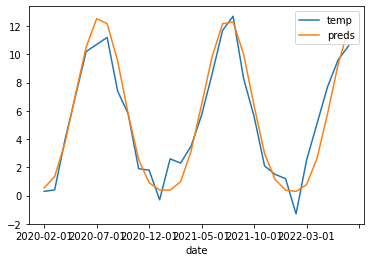

In [57]:
model_mix = Sequential()
model_mix.add(LSTM(100,activation='tanh',input_shape=(length,n_features),
                     return_sequences=True)) # tanh to use cuDNN
model_mix.add(LSTM(200,activation='tanh')) # tanh to use cuDNN
model_mix.add(Dense(200,activation='relu'))
#model_mix.add(Dropout(.4))
model_mix.add(Dense(100,activation='relu'))
model_mix.add(Dense(50,activation='relu'))
model_mix.add(Dense(1))
model_mix.compile(optimizer='adam',loss='mse')
check_model(model_mix)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 24, 128)           66560     
                                                                 
 lstm_35 (LSTM)              (None, 24, 256)           394240    
                                                                 
 lstm_36 (LSTM)              (None, 24, 512)           1574912   
                                                                 
 lstm_37 (LSTM)              (None, 24, 256)           787456    
                                                                 
 lstm_38 (LSTM)              (None, 128)               197120    
                                                                 
 dense_33 (Dense)            (None, 1)                 129       
                                                                 
Total params: 3,020,417
Trainable params: 3,020,417
N

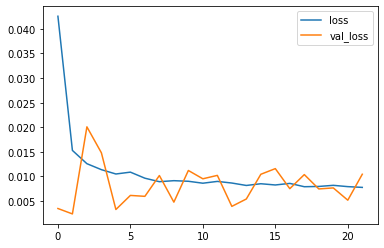

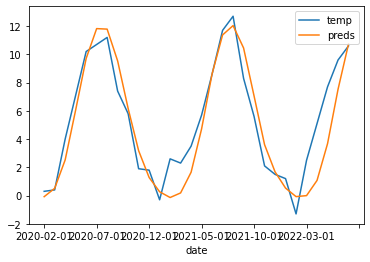

In [61]:
model_multi_LSTM = Sequential()
model_multi_LSTM.add(LSTM(128,activation='tanh',return_sequences=True,
                         input_shape=(length,n_features)))
model_multi_LSTM.add(LSTM(256,activation='tanh',return_sequences=True))
model_multi_LSTM.add(LSTM(512,activation='tanh',return_sequences=True))
model_multi_LSTM.add(LSTM(256,activation='tanh',return_sequences=True))
model_multi_LSTM.add(LSTM(128,activation='tanh'))
model_multi_LSTM.add(Dense(1))
model_multi_LSTM.compile(optimizer='adam',loss='mse')
check_model(model_multi_LSTM)

In [62]:
# the mixed model with LSTM and Dense layers performs the best (lowest RMSE)
# but is only marginally better than the simple single-layer LSTM model.
# Let's then choose simplicity over complexity and
# continue with the simple single-layer LSTM model

In [63]:
# Let's retrain using the full dataset in order to predict future temperatures

In [64]:
new_scaler = MinMaxScaler()
scaled_data = new_scaler.fit_transform(df)

In [65]:
generator = TimeseriesGenerator(scaled_data,scaled_data,length=length,batch_size=1)

In [66]:
# create the model and fit it to our data
model_final = Sequential()
model_final.add(LSTM(100,activation='tanh',input_shape=(length,n_features))) # tanh to use cuDNN
model_final.add(Dense(1))
model_final.compile(optimizer='adam',loss='mse')

model_final.fit(generator,epochs=35)

Epoch 1/35
859/859 [==============================] - 4s 3ms/step - loss: 0.0307
Epoch 2/35
859/859 [==============================] - 3s 4ms/step - loss: 0.0087
Epoch 3/35
859/859 [==============================] - 3s 3ms/step - loss: 0.0089
Epoch 4/35
859/859 [==============================] - 3s 4ms/step - loss: 0.0084
Epoch 5/35
859/859 [==============================] - 3s 3ms/step - loss: 0.0081
Epoch 6/35
859/859 [==============================] - 3s 4ms/step - loss: 0.0083
Epoch 7/35
859/859 [==============================] - 3s 4ms/step - loss: 0.0081
Epoch 8/35
859/859 [==============================] - 3s 4ms/step - loss: 0.0077
Epoch 9/35
859/859 [==============================] - 3s 4ms/step - loss: 0.0079
Epoch 10/35
859/859 [==============================] - 3s 4ms/step - loss: 0.0077
Epoch 11/35
859/859 [==============================] - 3s 4ms/step - loss: 0.0077
Epoch 12/35
859/859 [==============================] - 3s 4ms/step - loss: 0.0076
Epoch 13/35
859/859 [====

In [71]:
# create a function that takes in a model and number of months and returns predictions
def predict_temps(model,n_months):
    # empty list to fill out predicted temperatures
    future_temps = []
    
    # make a prediction from the tail of our timeseries
    ts_tail = scaled_data[-length:]
    
    # current timeseries batch to predict on that we will update for every prediction
    current_ts = ts_tail.reshape((1,length,n_features))
    
    # predict for as many months as we want (n_months)
    for _ in range(n_months):
        # predict one sample
        tmp_pred = model.predict(current_ts)[0]
        
        # add to prediction list
        future_temps.append(tmp_pred)
        
        # update current_ts based on new prediction
        current_ts = np.append(current_ts[:,1:,:],[[tmp_pred]],axis=1)
        
    # reverse the scaler transformation
    fixed_preds = new_scaler.inverse_transform(future_temps)
    
    return fixed_preds
    

In [72]:
# let's try predicting one and two years
one_year_preds = predict_temps(model_final,12)
two_year_preds = predict_temps(model_final,24)

In [73]:
# where does the original data end?
# we need to know in order to figure out the starting point for the predictions
df.tail()

,temp
date,
2022-03-01,2.5
2022-04-01,5.1
2022-05-01,7.7
2022-06-01,9.6
2022-07-01,10.6


In [79]:
# make a prediction dataframe with timestamps equal to the number 
# of predicted months where each date entry is the month start (MS)

# create the dates
pred_index_one_year = pd.date_range(start='2022-08-01',periods=12,freq='MS')
pred_index_two_year = pd.date_range(start='2022-08-01',periods=24,freq='MS')

# make the dataframes
pred_df_one_year = pd.DataFrame(data=one_year_preds,
                               index=pred_index_one_year,
                               columns=['temp'])
pred_df_one_year.index.name = 'date'
pred_df_two_year = pd.DataFrame(data=two_year_preds,
                               index=pred_index_two_year,
                               columns=['temp'])
pred_df_two_year.index.name = 'date'

In [80]:
pred_df_one_year

,temp
date,
2022-08-01,10.891509
2022-09-01,8.652280
2022-10-01,5.214378
2022-11-01,2.092052
2022-12-01,0.333647
2023-01-01,-0.241511
2023-02-01,-0.049300
2023-03-01,0.907117
2023-04-01,2.906982


In [81]:
pred_df_two_year

,temp
date,
2022-08-01,10.891509
2022-09-01,8.652280
2022-10-01,5.214378
2022-11-01,2.092052
2022-12-01,0.333647
2023-01-01,-0.241511
2023-02-01,-0.049300
2023-03-01,0.907117
2023-04-01,2.906982


In [108]:
# let's make dataframes with the original data and the predictions
# add a column with type (i.e. original data or prediction)
tmp_data = df.copy()
tmp_data['type'] = 'data'

In [109]:
tmp_data.head()

,temp,type
date,,
1949-01-01,-2.7,data
1949-02-01,0.0,data
1949-03-01,0.1,data
1949-04-01,-0.0,data
1949-05-01,3.6,data


In [115]:
tmp_one_year = pred_df_one_year.copy()
tmp_one_year['type'] = '1_year_pred'

tmp_two_year = pred_df_two_year.copy()
tmp_two_year['type'] = '2_year_pred'

In [111]:
tmp_one_year.head()

,temp,type
date,,
2022-08-01,10.891509,1_year_pred
2022-09-01,8.652280,1_year_pred
2022-10-01,5.214378,1_year_pred
2022-11-01,2.092052,1_year_pred
2022-12-01,0.333647,1_year_pred


In [116]:
# create dataframes consisting of original data and predictions
df_one_year = pd.concat([tmp_data,tmp_one_year])
df_two_year = pd.concat([tmp_data,tmp_two_year])

In [117]:
# fix the date column to be datetime
df_one_year.index = pd.to_datetime(df_one_year.index)
df_two_year.index = pd.to_datetime(df_two_year.index)

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

In [137]:
# plot the results
# two plots for each prediction batch:
# - all original data + predictions
# - original data since 2020-07-01 + predictions

<AxesSubplot:xlabel='date', ylabel='temp'>

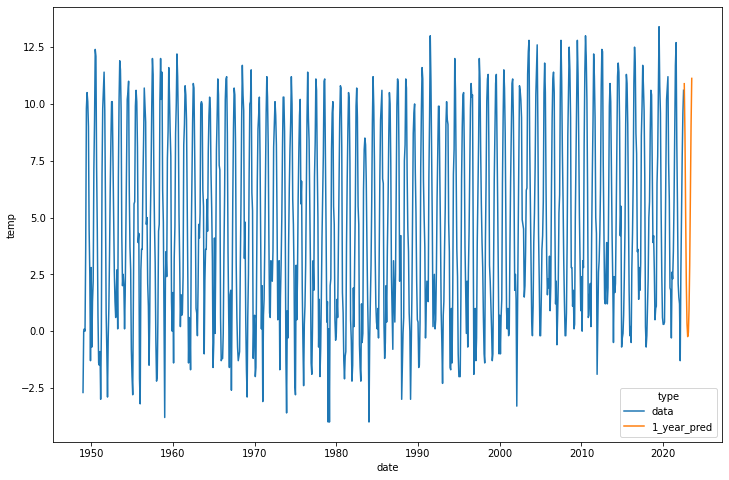

In [131]:
fig,ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=df_one_year,x=df_one_year.index,y='temp',hue='type',ax=ax)

<AxesSubplot:xlabel='date', ylabel='temp'>

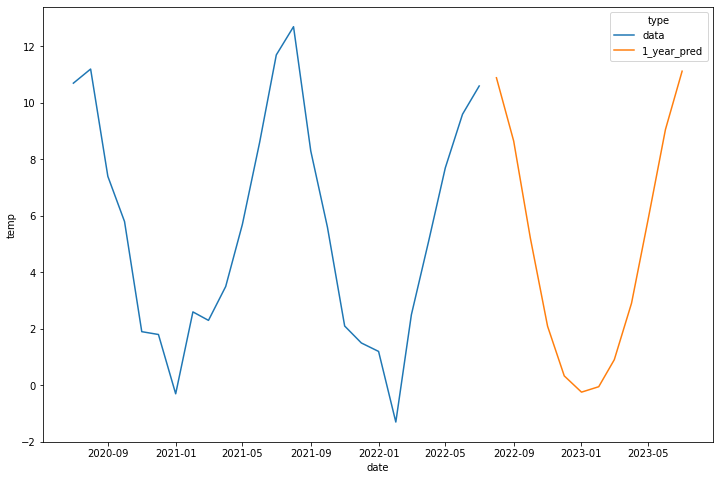

In [129]:
fig,ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=df_one_year.loc['2020-07-01':],x='date',y='temp',hue='type',ax=ax)

<AxesSubplot:xlabel='date', ylabel='temp'>

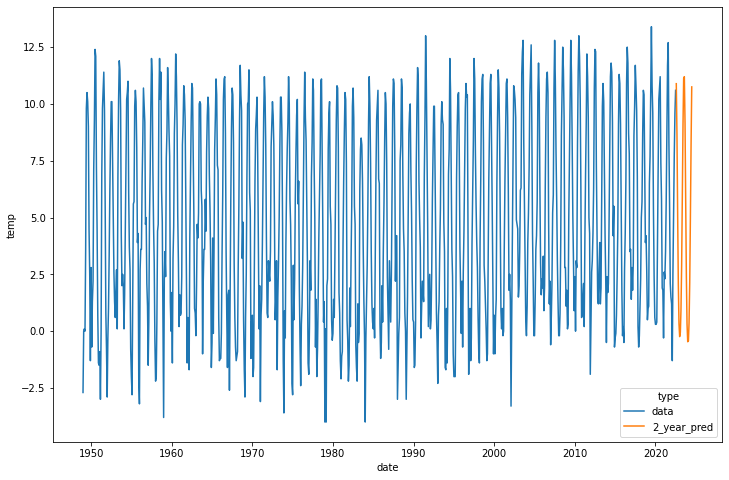

In [132]:
fig,ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=df_two_year,x=df_two_year.index,y='temp',hue='type',ax=ax)

<AxesSubplot:xlabel='date', ylabel='temp'>

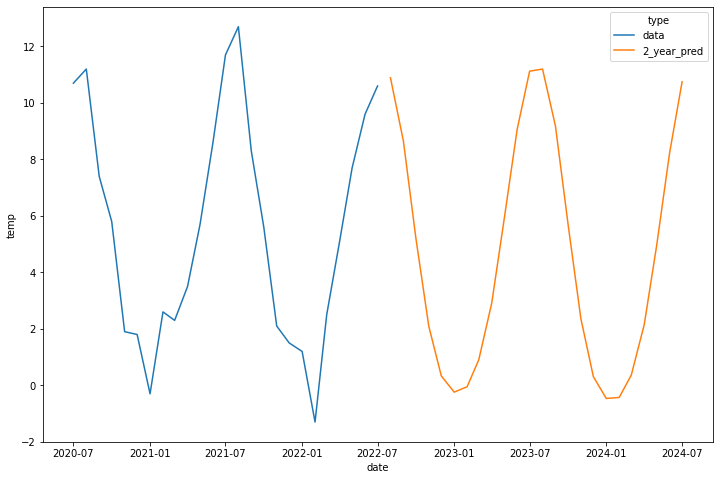

In [130]:
fig,ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=df_two_year.loc['2020-07-01':],x='date',y='temp',hue='type',ax=ax)

In [133]:
# let's try to see how predicting multiple years into the future goes

In [134]:
ten_year_preds = predict_temps(model_final,120)
pred_index_ten_year = pd.date_range(start='2022-08-01',periods=120,freq='MS')
pred_df_ten_year = pd.DataFrame(data=ten_year_preds,
                               index=pred_index_ten_year,
                               columns=['temp'])
pred_df_ten_year.index.name = 'date'
tmp_ten_year = pred_df_ten_year.copy()
tmp_ten_year['type'] = '10_year_pred'
df_ten_year = pd.concat([tmp_data,tmp_ten_year])
df_ten_year.index = pd.to_datetime(df_ten_year.index)


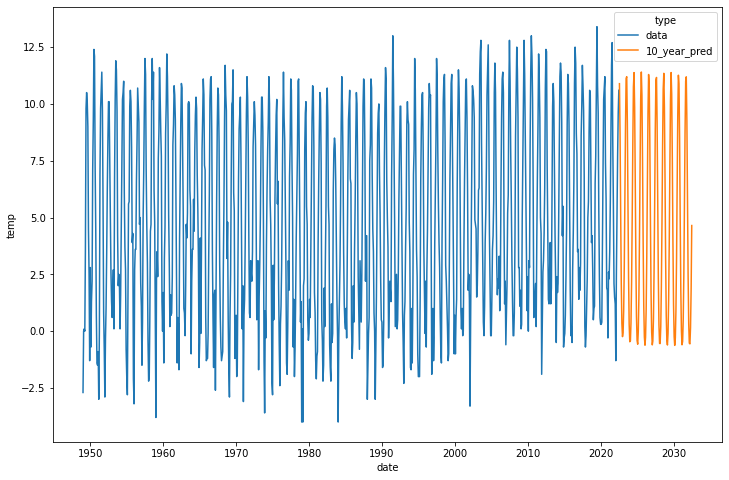

In [138]:
fig,ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=df_ten_year,x='date',y='temp',hue='type',ax=ax)
fig.savefig('ten_yr_prediction.png')

<AxesSubplot:xlabel='date', ylabel='temp'>

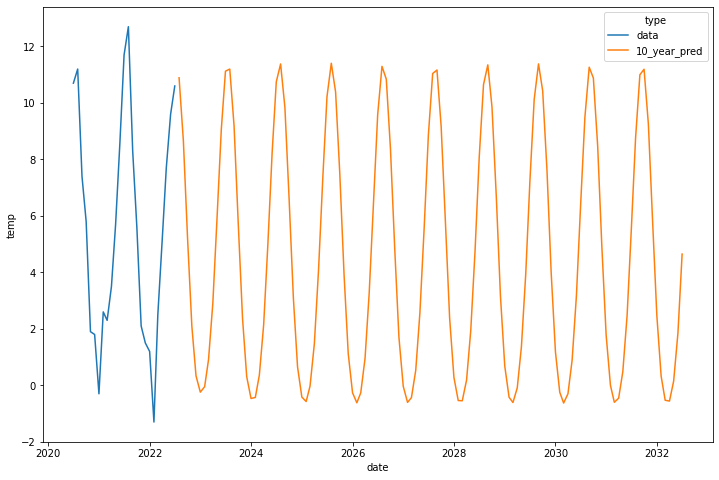

In [136]:
fig,ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=df_ten_year.loc['2020-07-01':],x='date',y='temp',hue='type',ax=ax)